In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN import TVDNDetect, TVDNRankTuning
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from scipy.signal import lfilter, firls, decimate

In [4]:
from pprint import pprint
import pickle
from easydict import EasyDict as edict
import warnings
from pyTVDN.TVDNutils import *
from pyTVDN.utils import in_notebook
if in_notebook():
    from tqdm import tqdm_notebook as tqdm
else:
    from tqdm import tqdm

class TVDNDetect1(TVDNDetect):
    def __init__(self, Ymat, ReconXmat, smoothType="Bspline", dataType=None, 
                 saveDir=None, showProgress=True, **paras):
        """
        Input:
            Ymat: The data matrix, d x n
            dataType: real data type, fMRI or MEG
            saveDir: Dir to save the results, if not specified, not save
            paras: Other parameters. There are default valuesi but you may specify these parameters manually.
               Inlcuding:
                    kappa: The parameter of penalty in MBIC
                    Lmin: The minimal length between 2 change points
                    r: The rank setted beforehand, in most cases, r=rAct. If we have non-complex singular values, r < rAct
                    MaxM: int, maximal number of change point 
                    lamb: The smooth parameter for B-spline
                    downRate: The downsample factor, determine how many Ai matrix to contribute to estimate the eigen values/vectors.
                    decimateRate: Mainly for MEG data. The rate to decimate from MEG data.
                    T: The time course
                    is_detrend: Whether detrend data or not
                    fct: The factor to adjust h when estimating A matrix
                    fName:  The file name when saving the results
                    plotfct: The factor to adjust the time course when plotting
                    freq: The parameter used drawing the eigen values plots
        """
        self.Ymat = Ymat
        self.paras = edict()
        if dataType is not None:
            self.dataType = dataType.lower()
        else:
            self.dataType = dataType

        if smoothType is not None:
            self.smoothType = smoothType.lower()
        else:
            self.smoothType = smoothType


        if self.dataType == "meg":
            self.paras.kappa = 2.65
            self.paras.Lmin = 60
            self.paras.r = 6
            self.paras.MaxM = 19
            self.paras.lamb = 1e-4
            self.paras.downRate = 20
            self.paras.decimateRate = 10
            self.paras.T = 2
            self.paras.is_detrend = False
            self.paras.fct = 0.5
            self.paras.fName = "MEG"
            self.paras.plotfct = 30
            self.paras.freq = 60
            self.paras.nbasis = 10
        elif self.dataType == "fmri":
            self.paras.kappa = 2.65
            self.paras.Lmin = 4
            self.paras.r = 6
            self.paras.MaxM = 10
            self.paras.lamb = 1e-4
            self.paras.downRate = 4
            self.paras.decimateRate = None
            self.paras.T = 2
            self.paras.is_detrend = False
            self.paras.fct = 0.5
            self.paras.fName = "fMRI"
            self.paras.plotfct = 180
            self.paras.freq = 0.5
            self.paras.nbasis = 10
        else:
            self.paras.kappa = 2.65
            self.paras.Lmin = 4
            self.paras.r = 6
            self.paras.MaxM = 19
            self.paras.lamb = 1e-6
            self.paras.downRate = 4
            self.paras.decimateRate = None
            self.paras.T = 2
            self.paras.is_detrend = False
            self.paras.fct = 1
            self.paras.fName = "simu"
            self.paras.plotfct = 1
            self.paras.freq = 180
            self.paras.nbasis = 10
        keys = list(self.paras.keys())
        for key in paras.keys():
            self.paras[key] = paras[key]
        if showProgress:
            print("The parameters for detection are:")
            pprint(self.paras)
        
        if saveDir is not None:
            self.saveDir = Path(saveDir)
            if not self.saveDir.exists():
                self.saveDir.mkdir()
        else:
            self.saveDir = saveDir
            
        self.ReconXmat = ReconXmat
        self.showProgress = showProgress
        self.nYmat = None
        self.Xmat = None
        self.dXmat = None
        self.time = None
        self.midRes = None
        self.nXmat = None
        self.ndXmat = None
        self.Amat = None
        self.finalRes = None
        self.RecYmatAll = None
        self.RecResCur = None
        self.numchgs = None
        self.ecpts = None
        self.canpts = None
    
    
    def GetRecResCur(self):
        numchg = len(self.ecpts)
        if self.RecYmatAll is not None:
            self.RecResCur = self.RecYmatAll[numchg]
        elif self.saveDir is not None:
            RecYmatAllPath = self.saveDir/f"{self.paras.fName}_Rank{self.paras.r}_RecAll.pkl"
            if RecYmatAllPath.exists():
                with open(RecYmatAllPath, "rb") as f:
                    self.RecYmatAll = pickle.load(f)
                self.RecResCur = self.RecYmatAll[numchg]
            else:
                MaxM = self.paras.MaxM
                r = self.paras.r
                finalRes = self.finalRes
                midRes = self.midRes
                _, n = midRes.nXmat.shape
                time = np.linspace(0, self.paras.T, n)
                tStep = np.diff(time)[0]
                ndXmat = midRes.ndXmat
                nXmat = midRes.nXmat
                kpidxs = midRes.kpidxs
                eigVecs = midRes.eigVecs
                self.RecResCur = self.ReconXmat(finalRes.chgMat[numchg-1, :numchg], ndXmat, nXmat, kpidxs, eigVecs, self.nYmat, tStep, r=r, is_full=True) 
        else:
            MaxM = self.paras.MaxM
            r = self.paras.r
            finalRes = self.finalRes
            midRes = self.midRes
            _, n = midRes.nXmat.shape
            time = np.linspace(0, self.paras.T, n)
            tStep = np.diff(time)[0]
            ndXmat = midRes.ndXmat
            nXmat = midRes.nXmat
            kpidxs = midRes.kpidxs
            eigVecs = midRes.eigVecs
            self.RecResCur = self.ReconXmat(finalRes.chgMat[numchg-1, :numchg], ndXmat, nXmat, kpidxs, eigVecs, self.nYmat, tStep, r=r, is_full=True) 
    
    def GetRecYmats(self):
        if self.RecYmatAll is None:
            RecYmatAll = []
            MaxM = self.paras.MaxM
            r = self.paras.r
            finalRes = self.finalRes
            midRes = self.midRes
            _, n = midRes.nXmat.shape
            time = np.linspace(0, self.paras.T, n)
            tStep = np.diff(time)[0]
            ndXmat = midRes.ndXmat
            nXmat = midRes.nXmat
            kpidxs = midRes.kpidxs
            eigVecs = midRes.eigVecs
            if self.showProgress:
                pbar = tqdm(range(MaxM+1))
                for numchg in pbar:
                    pbar.set_description(f"Kappa Tuning")
        #            print(f"Current number of change point is {numchg}.")
                    if numchg == 0:
                        RecResCur = self.ReconXmat([], ndXmat, nXmat, kpidxs, eigVecs, self.nYmat, tStep, r=r, is_full=True) 
                    else:
                        RecResCur = self.ReconXmat(finalRes.chgMat[numchg-1, :numchg], ndXmat, nXmat, kpidxs, eigVecs, self.nYmat, tStep, r=r, is_full=True) 
                    RecYmatAll.append(RecResCur)
            else:
                for numchg in range(MaxM+1):
                    if numchg == 0:
                        RecResCur = self.ReconXmat([], ndXmat, nXmat, kpidxs, eigVecs, self.nYmat, tStep, r=r, is_full=True) 
                    else:
                        RecResCur = self.ReconXmat(finalRes.chgMat[numchg-1, :numchg], ndXmat, nXmat, kpidxs, eigVecs, self.nYmat, tStep, r=r, is_full=True) 
                    RecYmatAll.append(RecResCur)
            self.RecYmatAll = RecYmatAll

In [5]:
# Reconstruct Xmat from results
def ReconXmatNew(ecpts, ndXmat, nXmat, kpidxs, eigVecs, Ymat, tStep, r, is_full=False):
    """
    Input: 
        ecpts: Estimated change points, 
        ndXmat: a rAct x n matrix
        nXmat: a rAct x n matrix
        kpidxs: The intermedian output when calculating ndXmat, nXmat
        eigVecs: The matrix of eigen vectors of A matrix, d x d
        Ymat: The matrix to construct, d x n 
        tStep: The time step
        r: The rank setted beforehand, in most cases, r=rAct. If we have non-complex singular values, r < rAct
        if_full: Where outputing full info or not

    Return:
        Estimated Xmat, d x n
    """
    print(f"The class calls the new reconstruction function, ReconXmatNew")
    rAct, n = ndXmat.shape
    d, _ = Ymat.shape
    ecptsfull = np.concatenate(([0], ecpts, [n])) - 1
    ecptsfull = ecptsfull.astype(np.int)
    numchgfull = len(ecptsfull)

    ResegS = np.zeros((numchgfull-1, r), dtype=np.complex)
    for  itr in range(numchgfull-1):
        lower = ecptsfull[itr] + 1
        upper = ecptsfull[itr+1] + 1
        Ycur = ndXmat[:, lower:upper]
        Xcur = nXmat[:, lower:upper]
        lams = np.zeros(r, dtype=np.complex) + np.inf
        for j in range(int(rAct/2)):
            tY = Ycur[(2*j):(2*j+2), :]
            tX = Xcur[(2*j):(2*j+2), :]
            corY = tY.dot(tX.T)
            corX = np.trace(tX.dot(tX.T))
            a = np.trace(corY)/corX
            b = (corY[1, 0] - corY[0, 1])/corX
            lams[kpidxs[j]] = a + b*1j
        tmpIdx = np.where(lams==np.inf)[0]
        lams[tmpIdx] = np.conjugate(lams[tmpIdx-1])
        ResegS[itr, :] = lams
    
    LamMs = np.zeros((r, n), dtype=np.complex)
    LamMs[:, 0] = ResegS[0, :]
    for itr in range(1, numchgfull):
        lower = ecptsfull[itr-1] + 1
        upper = ecptsfull[itr] + 1
        LamMs[:, lower:upper] = ResegS[itr-1, ].reshape(-1, 1)
    
    EstXmat = np.zeros((d, n), dtype=np.complex)
    EstXmat[:, 0] = Ymat[:, 0]
    invEigVecsr = inv(eigVecs)[:r, :]
    eigVecsr = eigVecs[:, :r]
    for i in range(1, n):
        if i in ecpts:
            EstXmat[:, i] = Ymat[:, i]
        else:
            mTerm = np.diag(LamMs[:, i])
            rTerm = invEigVecsr.dot(EstXmat[:, i-1])
            EstXmat[:, i] = eigVecsr.dot(mTerm).dot(rTerm) * tStep + EstXmat[:,i-1]
        
    if is_full:
        ReDict = edict()
        ReDict.EstXmatReal = detrend(EstXmat.real)
        ReDict.EstXmatRealOrg = EstXmat.real
        ReDict.EstXmatImag = EstXmat.imag
        ReDict.LamMs = LamMs
        return ReDict
    else:
        return detrend(EstXmat.real)

In [6]:
resDir = Path("../results")
dataDir = Path("../data")

In [7]:
filname = Path("fMRI_samples.mat")
fMRIs = loadmat(dataDir/filname)["clean_subjects"]

# 1. Obtain data after HPF

In [8]:
fs = 0.5 #sampling frequency
fmin = 0.009 # 
fmax = 0.08
hbp = firls(21, np.array([0, 0.009, 0.01, 0.08, 0.09, 0.8]), #0.8
           desired = np.array([0, 0, 1, 1, 0, 0]))

In [9]:
num = 243
fMRIsHPF = []
for i in range(num):
    cfMRI = fMRIs[0, i]["fMRI"][:90, :]
    # detrend
    cfMRI = detrend(cfMRI)
    chpffMRI = lfilter(hbp, 1, cfMRI)
    fMRIsHPF.append(chpffMRI[:, 25:])

### sample plots 

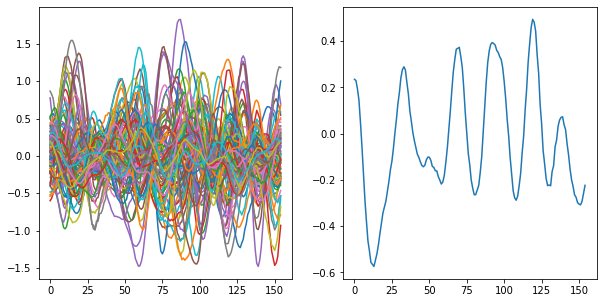

In [10]:
plt.figure(figsize=[10, 5])
plt.subplot(121)
for i in range(90):
    plt.plot(fMRIsHPF[4][i, :])
    
plt.subplot(122)
plt.plot(fMRIsHPF[4][10, :])

In [11]:
kappas = np.arange(1, 4, 0.01)
ranks = [2, 4, 6, 8, 10, 12]

# 2. data 9

In [12]:
Ymat = fMRIsHPF[9]
Lmin = 4
lamb = 8e-5

In [13]:
res = TVDNRankTuning(ranks=ranks, kappas=kappas, Ymat=Ymat, dataType="fMRI", 
                     saveDir=None, Lmin=Lmin, lamb=lamb, MaxM=20, is_detrend=False)

The current rank is 2.
The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.0,
 'lamb': 8e-05,
 'nbasis': 10,
 'r': 2}



The current rank is 4.
The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.0,
 'lamb': 8e-05,
 'nbasis': 10,
 'r': 4}



The current rank is 6.
The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.0,
 'lamb': 8e-05,
 'nbasis': 10,
 'r': 6}



The current rank is 8.
The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.0,
 'lamb': 8e-05,
 'nbasis': 10,
 'r': 8}



The current rank is 10.
The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.0,
 'lamb': 8e-05,
 'nbasis': 10,
 'r': 10}



The current rank is 12.
The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.0,
 'lamb': 8e-05,
 'nbasis': 10,
 'r': 12}


In [14]:
res

{'minErr': 1.0453856844363956,
 'optRank': 2,
 'optKappa': array([1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 , 1.21, 1.22,
        1.23]),
 'DetectObj': <pyTVDN.TVDNclass.TVDNDetect at 0x7fa40bd9da90>}

In [15]:
optDet = res.DetectObj
optRank = res.optRank
optKp = res.optKappa[0]

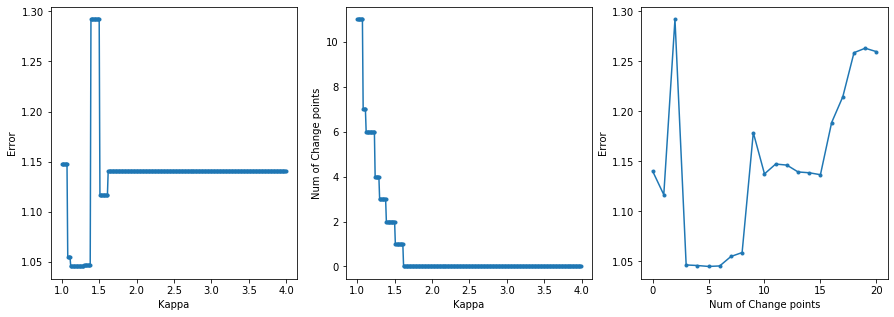

In [16]:
optDet.PlotKappaErrCurve()

In [17]:
print(optDet)

+-------------+---------------------------------+--------------------+------+
| Num of CPTs |          Estiamted CPTs         |        MSE         | Rank |
+-------------+---------------------------------+--------------------+------+
|      6      | [ 21.  65.  82.  95. 108. 135.] | 1.0453856844363956 |  2   |
+-------------+---------------------------------+--------------------+------+


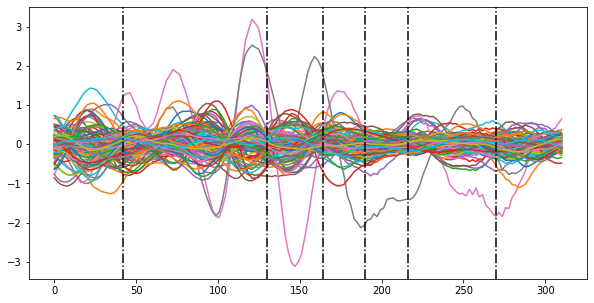

In [18]:
optDet.PlotEcpts()

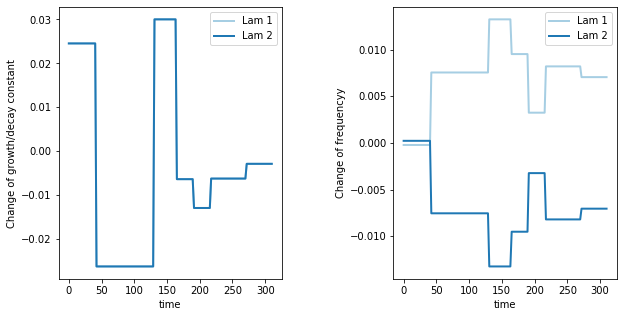

In [19]:
optDet.PlotEigenCurve()

In [20]:
DetRec = TVDNDetect1(Ymat=Ymat, ReconXmat=ReconXmatNew, dataType="fMRI", MaxM=20,
                      saveDir=None, showProgress=True, Lmin=Lmin, lamb=lamb, kappa=optKp, r=optRank)
DetRec()

The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.12,
 'lamb': 8e-05,
 'nbasis': 10,
 'plotfct': 180,
 'r': 2}



The class calls the new reconstruction function, ReconXmatNew


### Reconstruction 1 vs 2(segment)

The plot indices are [82  2 46 31 32].


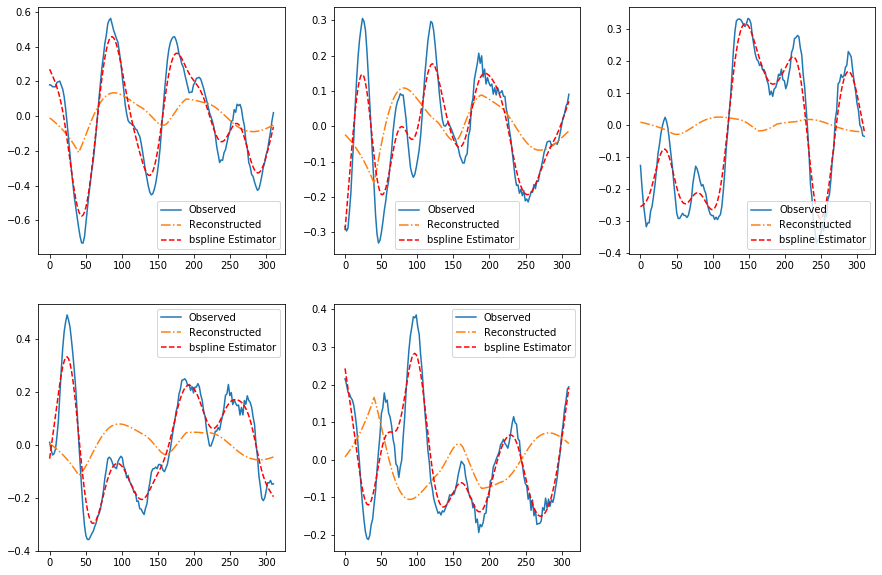

The plot indices are [82  2 46 31 32].


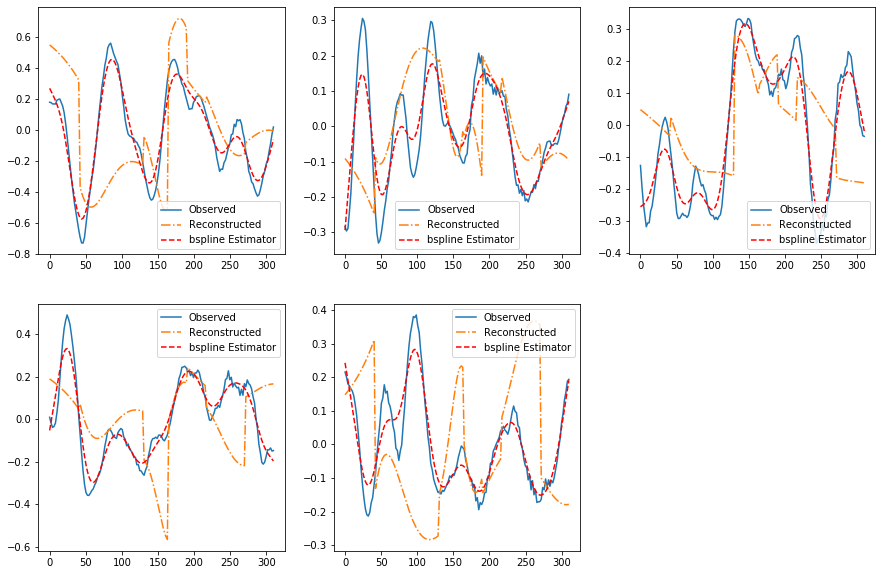

array([82,  2, 46, 31, 32])

In [21]:
idxs = optDet.PlotRecCurve(is_smoothCurve=1)
DetRec.PlotRecCurve(idxs=idxs, is_smoothCurve=1)

# 3. data 90

In [22]:
Ymat = fMRIsHPF[90]
Lmin = 4
lamb = 8e-5

In [23]:
res = TVDNRankTuning(ranks=ranks, kappas=kappas, Ymat=Ymat, dataType="fMRI", 
                     saveDir=None, Lmin=Lmin, lamb=lamb, MaxM=20, is_detrend=False)

The current rank is 2.
The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.0,
 'lamb': 8e-05,
 'nbasis': 10,
 'r': 2}



The current rank is 4.
The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.0,
 'lamb': 8e-05,
 'nbasis': 10,
 'r': 4}



The current rank is 6.
The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.0,
 'lamb': 8e-05,
 'nbasis': 10,
 'r': 6}



The current rank is 8.
The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.0,
 'lamb': 8e-05,
 'nbasis': 10,
 'r': 8}



The current rank is 10.
The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.0,
 'lamb': 8e-05,
 'nbasis': 10,
 'r': 10}



The current rank is 12.
The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.0,
 'lamb': 8e-05,
 'nbasis': 10,
 'r': 12}


In [24]:
res

{'minErr': 1.54272969675372,
 'optRank': 6,
 'optKappa': array([1.52]),
 'DetectObj': <pyTVDN.TVDNclass.TVDNDetect at 0x7fa3d02ddb00>}

In [25]:
optDet = res.DetectObj
optRank = res.optRank
optKp = res.optKappa[0]

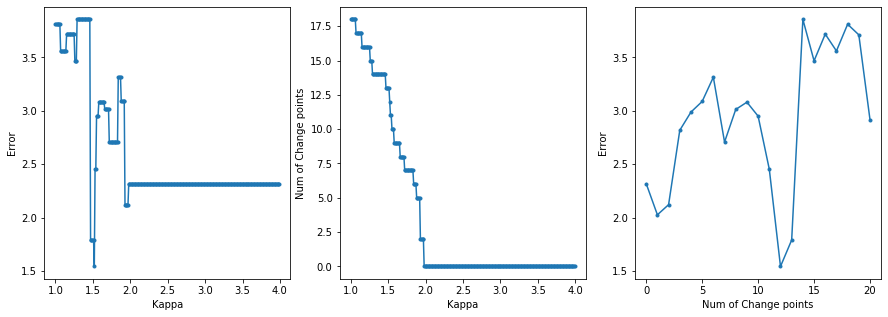

In [26]:
optDet.PlotKappaErrCurve()

In [27]:
print(optDet)

+-------------+---------------------------------------------------------------+------------------+------+
| Num of CPTs |                         Estiamted CPTs                        |       MSE        | Rank |
+-------------+---------------------------------------------------------------+------------------+------+
|      12     | [ 11.  22.  35.  50.  64.  77.  87. 102. 111. 123. 134. 143.] | 1.54272969675372 |  6   |
+-------------+---------------------------------------------------------------+------------------+------+


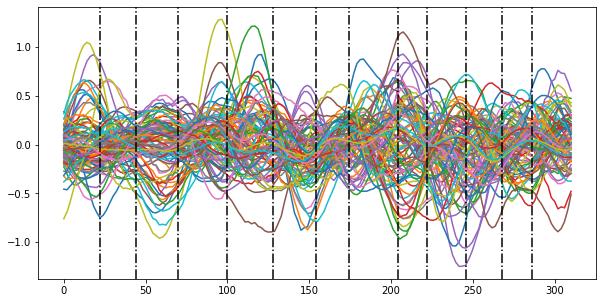

In [28]:
optDet.PlotEcpts()

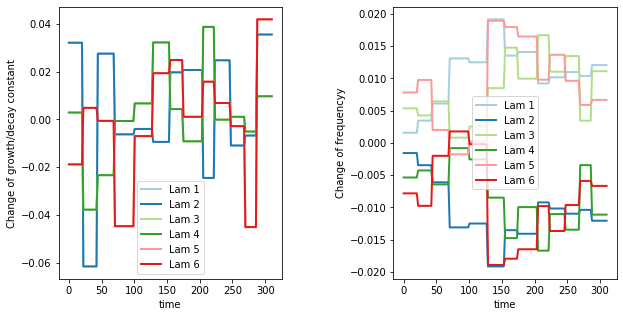

In [29]:
optDet.PlotEigenCurve()

In [30]:
DetRec = TVDNDetect1(Ymat=Ymat, ReconXmat=ReconXmatNew, dataType="fMRI", MaxM=20,
                      saveDir=None, showProgress=True, Lmin=Lmin, lamb=lamb, kappa=optKp, r=optRank)
DetRec()

The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.5200000000000005,
 'lamb': 8e-05,
 'nbasis': 10,
 'plotfct': 180,
 'r': 6}



The class calls the new reconstruction function, ReconXmatNew


### Reconstruction 1 vs 2(segment)

The plot indices are [ 4 55 57 40 31].


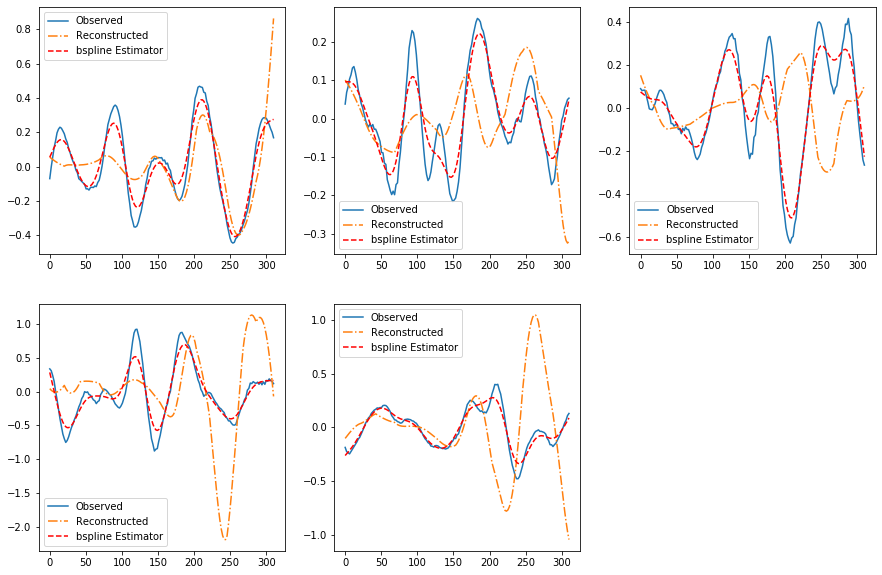

The plot indices are [ 4 55 57 40 31].


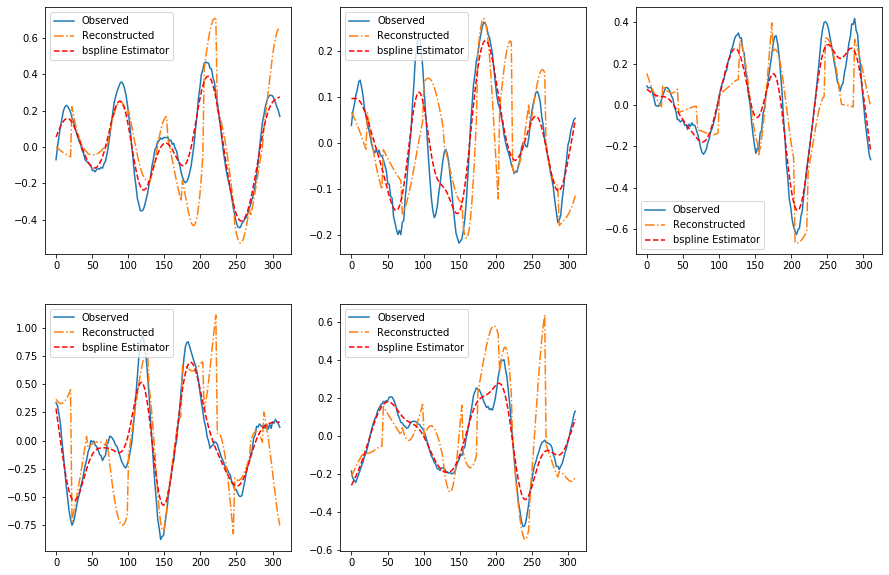

array([ 4, 55, 57, 40, 31])

In [31]:
idxs = optDet.PlotRecCurve(is_smoothCurve=1)
DetRec.PlotRecCurve(idxs=idxs, is_smoothCurve=1)

# 4. data 100

In [32]:
Ymat = fMRIsHPF[100]
Lmin = 4
lamb = 8e-5

In [33]:
res = TVDNRankTuning(ranks=ranks, kappas=kappas, Ymat=Ymat, dataType="fMRI", 
                     saveDir=None, Lmin=Lmin, lamb=lamb, MaxM=20, is_detrend=False)

The current rank is 2.
The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.0,
 'lamb': 8e-05,
 'nbasis': 10,
 'r': 2}



The current rank is 4.
The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.0,
 'lamb': 8e-05,
 'nbasis': 10,
 'r': 4}



The current rank is 6.
The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.0,
 'lamb': 8e-05,
 'nbasis': 10,
 'r': 6}



The current rank is 8.
The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.0,
 'lamb': 8e-05,
 'nbasis': 10,
 'r': 8}



The current rank is 10.
The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.0,
 'lamb': 8e-05,
 'nbasis': 10,
 'r': 10}



The current rank is 12.
The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.0,
 'lamb': 8e-05,
 'nbasis': 10,
 'r': 12}


In [34]:
res

{'minErr': 1.1637868164021332,
 'optRank': 6,
 'optKappa': array([1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.  , 2.01, 2.02, 2.03, 2.04,
        2.05, 2.06, 2.07, 2.08, 2.09, 2.1 , 2.11, 2.12, 2.13, 2.14, 2.15,
        2.16, 2.17, 2.18, 2.19, 2.2 , 2.21, 2.22, 2.23, 2.24, 2.25, 2.26,
        2.27, 2.28, 2.29, 2.3 , 2.31, 2.32, 2.33, 2.34, 2.35, 2.36, 2.37,
        2.38, 2.39, 2.4 , 2.41, 2.42, 2.43, 2.44, 2.45, 2.46, 2.47, 2.48,
        2.49, 2.5 , 2.51, 2.52, 2.53, 2.54, 2.55, 2.56, 2.57, 2.58, 2.59,
        2.6 , 2.61, 2.62, 2.63, 2.64, 2.65, 2.66, 2.67, 2.68, 2.69, 2.7 ,
        2.71, 2.72, 2.73, 2.74, 2.75, 2.76, 2.77, 2.78, 2.79, 2.8 , 2.81,
        2.82, 2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9 , 2.91, 2.92,
        2.93, 2.94, 2.95, 2.96, 2.97, 2.98, 2.99, 3.  , 3.01, 3.02, 3.03,
        3.04, 3.05, 3.06, 3.07, 3.08, 3.09, 3.1 , 3.11, 3.12, 3.13, 3.14,
        3.15, 3.16, 3.17, 3.18, 3.19, 3.2 , 3.21, 3.22, 3.23, 3.24, 3.25,
        3.26, 3.27, 3.28, 3.29, 3.3 , 3.31, 3.32, 3.33

In [35]:
optDet = res.DetectObj
optRank = res.optRank
optKp = res.optKappa[0]

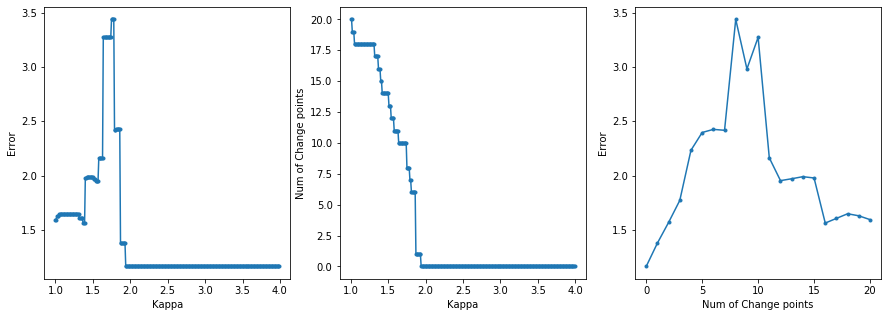

In [36]:
optDet.PlotKappaErrCurve()

In [37]:
print(optDet)

+-------------+----------------+--------------------+------+
| Num of CPTs | Estiamted CPTs |        MSE         | Rank |
+-------------+----------------+--------------------+------+
|      0      |       []       | 1.1637868164021332 |  6   |
+-------------+----------------+--------------------+------+


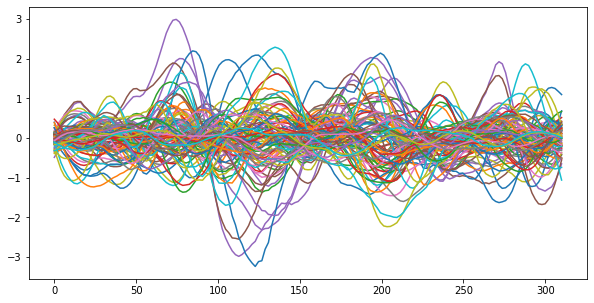

In [38]:
optDet.PlotEcpts()

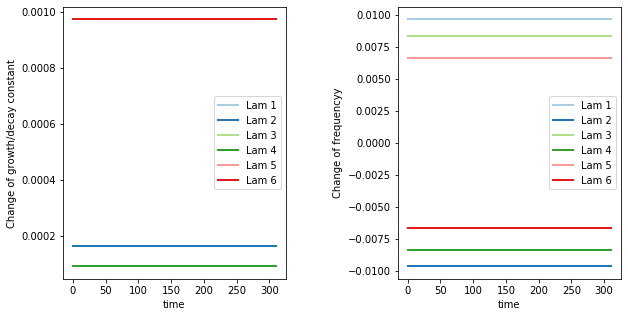

In [39]:
optDet.PlotEigenCurve()

In [40]:
DetRec = TVDNDetect1(Ymat=Ymat, ReconXmat=ReconXmatNew, dataType="fMRI", MaxM=20,
                      saveDir=None, showProgress=True, Lmin=Lmin, lamb=lamb, kappa=optKp, r=optRank)
DetRec()

The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.9400000000000008,
 'lamb': 8e-05,
 'nbasis': 10,
 'plotfct': 180,
 'r': 6}



The class calls the new reconstruction function, ReconXmatNew


### Reconstruction 1 vs 2(segment)

The plot indices are [76 40 60 58 44].


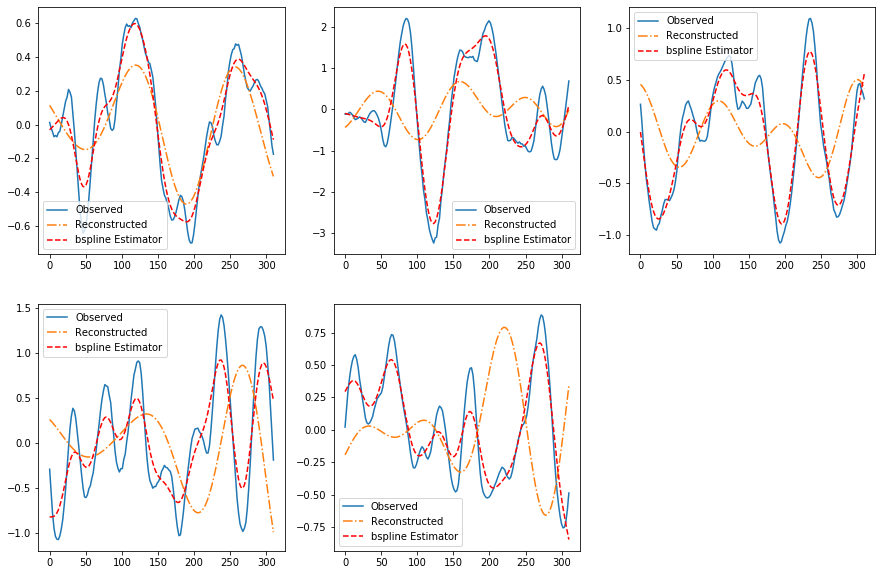

The plot indices are [76 40 60 58 44].


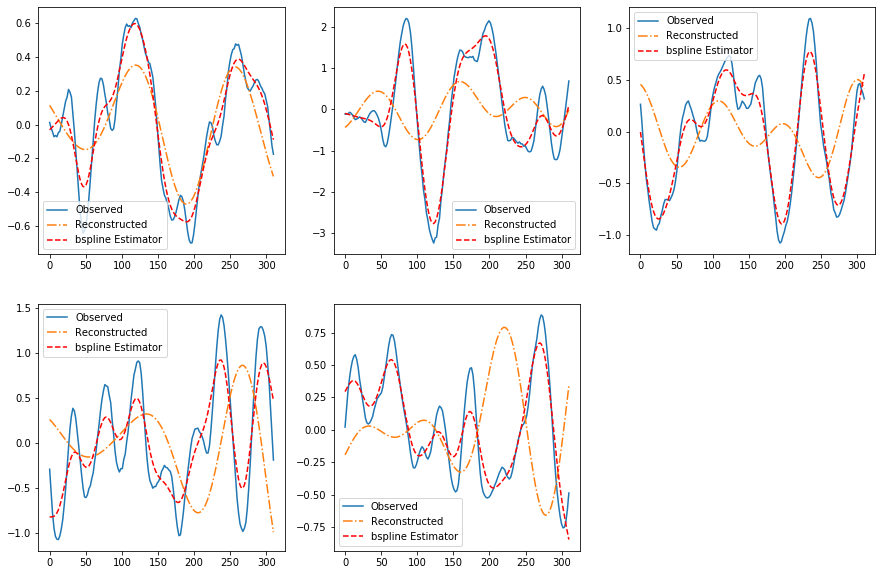

array([76, 40, 60, 58, 44])

In [41]:
idxs = optDet.PlotRecCurve(is_smoothCurve=1)
DetRec.PlotRecCurve(idxs=idxs, is_smoothCurve=1)

# 5. data 150

In [42]:
Ymat = fMRIsHPF[150]
Lmin = 4
lamb = 8e-5

In [43]:
res = TVDNRankTuning(ranks=ranks, kappas=kappas, Ymat=Ymat, dataType="fMRI", 
                     saveDir=None, Lmin=Lmin, lamb=lamb, MaxM=20, is_detrend=False)

The current rank is 2.
The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.0,
 'lamb': 8e-05,
 'nbasis': 10,
 'r': 2}



The current rank is 4.
The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.0,
 'lamb': 8e-05,
 'nbasis': 10,
 'r': 4}



The current rank is 6.
The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.0,
 'lamb': 8e-05,
 'nbasis': 10,
 'r': 6}



The current rank is 8.
The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.0,
 'lamb': 8e-05,
 'nbasis': 10,
 'r': 8}



The current rank is 10.
The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.0,
 'lamb': 8e-05,
 'nbasis': 10,
 'r': 10}



The current rank is 12.
The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.0,
 'lamb': 8e-05,
 'nbasis': 10,
 'r': 12}


In [44]:
res

{'minErr': 1.0218565203210404,
 'optRank': 4,
 'optKappa': array([1.38]),
 'DetectObj': <pyTVDN.TVDNclass.TVDNDetect at 0x7fa40bb072e8>}

In [45]:
optDet = res.DetectObj
optRank = res.optRank
optKp = res.optKappa[0]

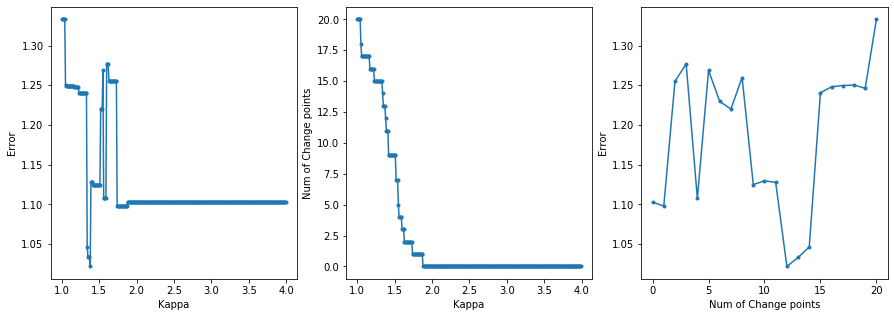

In [46]:
optDet.PlotKappaErrCurve()

In [47]:
print(optDet)

+-------------+---------------------------------------------------------------+--------------------+------+
| Num of CPTs |                         Estiamted CPTs                        |        MSE         | Rank |
+-------------+---------------------------------------------------------------+--------------------+------+
|      12     | [  6.  26.  36.  52.  62.  78.  84.  99. 103. 112. 120. 137.] | 1.0218565203210404 |  4   |
+-------------+---------------------------------------------------------------+--------------------+------+


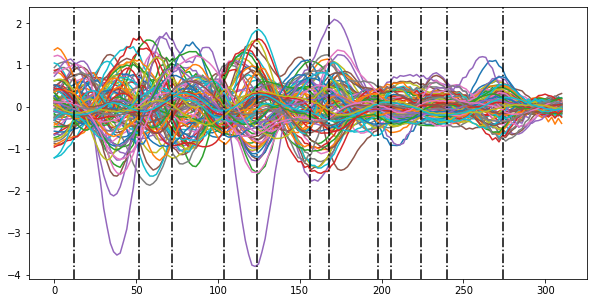

In [48]:
optDet.PlotEcpts()

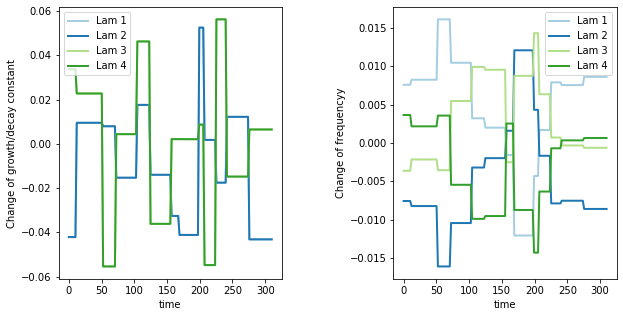

In [49]:
optDet.PlotEigenCurve()

In [50]:
DetRec = TVDNDetect1(Ymat=Ymat, ReconXmat=ReconXmatNew, dataType="fMRI", MaxM=20,
                      saveDir=None, showProgress=True, Lmin=Lmin, lamb=lamb, kappa=optKp, r=optRank)
DetRec()

The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.3800000000000003,
 'lamb': 8e-05,
 'nbasis': 10,
 'plotfct': 180,
 'r': 4}



The class calls the new reconstruction function, ReconXmatNew


### Reconstruction 1 vs 2(segment)

The plot indices are [84  5 40  0 10].


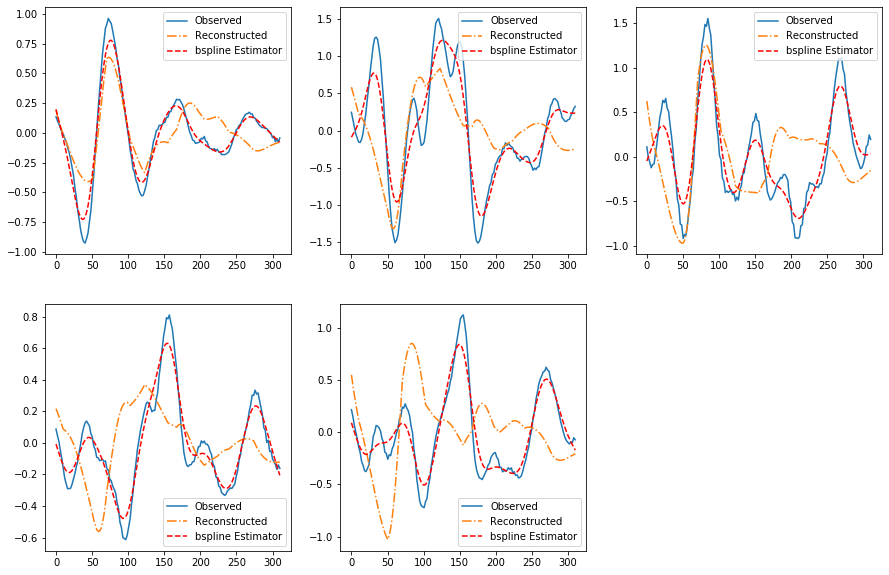

The plot indices are [84  5 40  0 10].


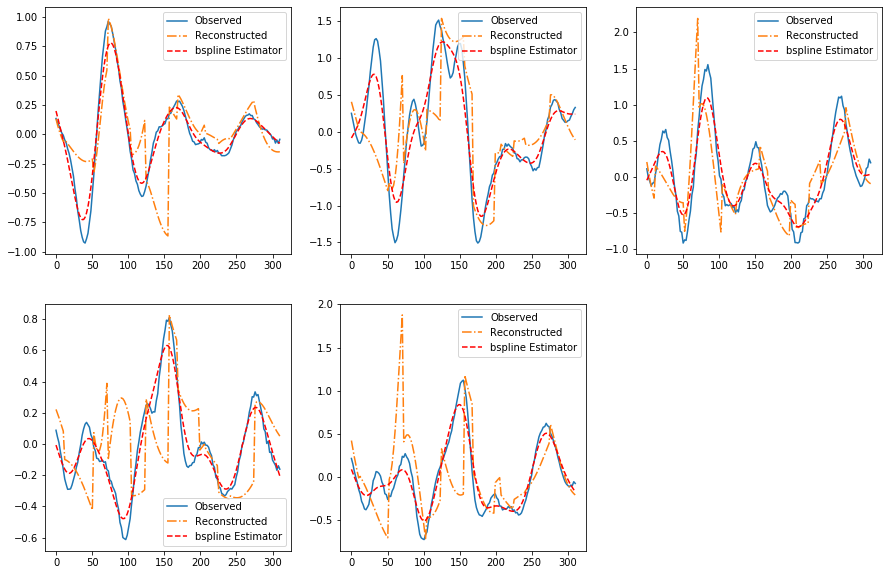

array([84,  5, 40,  0, 10])

In [51]:
idxs = optDet.PlotRecCurve(is_smoothCurve=1)
DetRec.PlotRecCurve(idxs=idxs, is_smoothCurve=1)